# Tutorial 1

**Linear Algebra IV: Matrix Decomposition & Dimensionality Reduction**

**[insert your name]**

**Important reminders**: Before starting, click "File -> Save a copy in Drive". Produce a pdf for submission by "File -> Print" and then choose "Save to PDF".

To complete this tutorial, you should have watched Videos 5.1, 5.2, and 5.3.



**Credits**:  Exercise 2/3 in this tutorial are modified from content in NMA W1D5 tutorials.

We are again using code for visualizing linear transformations from https://openedx.seas.gwu.edu/courses/course-v1:GW+EngComp4+2019/about. In particular, we are using their `plot_linear_transformation` and `plot_linear_transformations` functions.

The interactive demo in Exercise 2A is based on matlab code from: https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

 Imports


In [1]:
# @markdown Imports

# Imports
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display


 Plotting functions


In [2]:
# @markdown Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle


%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

classic = 'k'

_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}
def plot_sample_images(X):
  """
  Plots 9 images from the data.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """
  im_size = int(np.sqrt(X.shape[1]))
  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (im_size, im_size)),
                 extent=[(k1 + 1) * im_size, k1 * im_size, (k2+1) * im_size, k2 * im_size],
                 vmin=0, vmax=255, cmap='gray')
  plt.xlim((3 * im_size, 0))
  plt.ylim((3 * im_size, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

def plot_reconstructions(X, X_reconstructed):
  """
  Plots 9 images in the dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  im_size = int(np.sqrt(X.shape[1]))

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (im_size, im_size)),
                 extent=[(k1 + 1) * im_size, k1 * im_size, (k2 + 1) * im_size, k2 * im_size],
                 vmin=0, vmax=255, cmap='gray')
  plt.xlim((3 * im_size, 0))
  plt.ylim((3 * im_size, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (im_size, im_size)),
                 extent=[(k1 + 1) * im_size, k1 * im_size, (k2 + 1) * im_size, k2 * im_size],
                 vmin=0, vmax=255, cmap='gray')
  plt.xlim((3 * im_size, 0))
  plt.ylim((3 * im_size, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()

def plot_principal_components(weights):
  """
  Visualize PCA basis vector weights. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """
  im_size = int(np.sqrt(X.shape[1]))

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (im_size, im_size))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_pca_transformation(data, transformed_data):


    fig, axes = plt.subplots(1, 2)
    axes[0].scatter(data[:,0], data[:, 1], s=1, c='#63BA79');
    for j in range(2):
      axes[j].spines['right'].set_visible(False)
      axes[j].spines['top'].set_visible(False)

    orig_correlation = round(np.corrcoef(data[:, 0], data[:, 1])[0, 1], 2)
    axes[0].set(title='Data in original coordinates \n Correlation = ' + str(orig_correlation), xlabel='Neuron 1 activity', ylabel='Neuron 2 activity', xlim=[-5, 15], ylim=[-5, 15]);

    axes[1].scatter(transformed_data[:,0], transformed_data[:, 1], s=1, c='#63BA79');
    pca_correlation = round(np.corrcoef(transformed_data[:, 0], transformed_data[:, 1])[0, 1], 2)
    axes[1].set(title='Data in PC coordinates  \n Correlation = ' + str(pca_correlation), xlabel='PC 1', ylabel='PC 2');

    plt.tight_layout()

def plot_data_and_PCs(X, W):
  """
  Plots bivariate data as well as new basis vectors.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
    W (numpy array of floats) : Square matrix representing new orthonormal
                                basis each column represents a basis vector

  Returns:
    Nothing.
  """

  plt.figure()
  plt.scatter(X[:, 0], X[:, 1], s=1, color='#63BA79')
  plt.axis('equal')
  plt.xlabel('Neuron 1 activity')
  plt.ylabel('Neuron 2 activity')
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  plt.plot([0, W[0, 0]], [0, W[1, 0]], color=colors[4], linewidth=1,
           label='Component 1')
  plt.plot([0, W[0, 1]], [0, W[1, 1]], color=colors[3], linewidth=1,
           label='Component 2')
  plt.legend()
  plt.show()


def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.

    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.

    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.

    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

    '''
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)

    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins

    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue,
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)

    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')

def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.

    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.

    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    title: str, optional.
        Title of the plot.

    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)

    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)

    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)

def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.

    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.

    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    """
    with plt.rc_context({"figure.dpi": 200, 'font.family':'serif', 'axes.axisbelow':True, 'font.size':fontsize, "axes.titlesize":5, "lines.linewidth":1}):
      figsize = numpy.array([4,2]) * fig_scale
      figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
      plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
      plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')

def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.

    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.

    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.

    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.

    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    with plt.rc_context({"figure.dpi": 200, 'font.family':'serif', 'axes.axisbelow':True, 'font.size':fontsize, "axes.titlesize":5, "lines.linewidth":1}):
      figsize = numpy.array([2*nx, 2*ny]) * fig_scale
      figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

      for i in range(nplots):  # fig_idx
          if i == 0:
              matrix_trans = numpy.identity(2)
              title = 'Before transformation'
          else:
              matrix_trans = matrices[i-1] @ matrix_trans
              if i == 1:
                  title = 'After {} transformation'.format(i)
              else:
                  title = 'After {} transformations'.format(i)
          plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
      # hide axes of the extra subplot (only when nplots is an odd number)
      if nx*ny > nplots:
          axes[-1,-1].axis('off')

 Helper functions


In [3]:
# @markdown Helper functions
def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors

def calculate_cov_matrix(var_1, var_2, corr_coef):
  """
  Calculates the covariance matrix based on the variances and
  correlation coefficient.

  Args:
    var_1 (scalar)         :  variance of the first random variable
    var_2 (scalar)         :  variance of the second random variable
    corr_coef (scalar)     :  correlation coefficient

  Returns:
    (numpy array of floats) : covariance matrix
  """
  cov = corr_coef * np.sqrt(var_1 * var_2)
  cov_matrix = np.array([[var_1, cov], [cov, var_2]])
  return cov_matrix

def get_variance_explained(evals):
  """
  Plots eigenvalues.

  Args:
    (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  # cumulatively sum the eigenvalues
  csum = np.cumsum(evals)
  # normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained

def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


# Exercise 1: Delving into SVD

We'll explore SVD by hand in this problem to help solidify our understanding of how the matrices interact with each other. Let $$A = \begin{bmatrix}
2 & -4 \\
3 & 1 \\
\end{bmatrix}, \bar{v} = \begin{bmatrix}
2 \\
1 \\
\end{bmatrix}$$

In the following plot, we'll see the transformation that this matrix enacts.


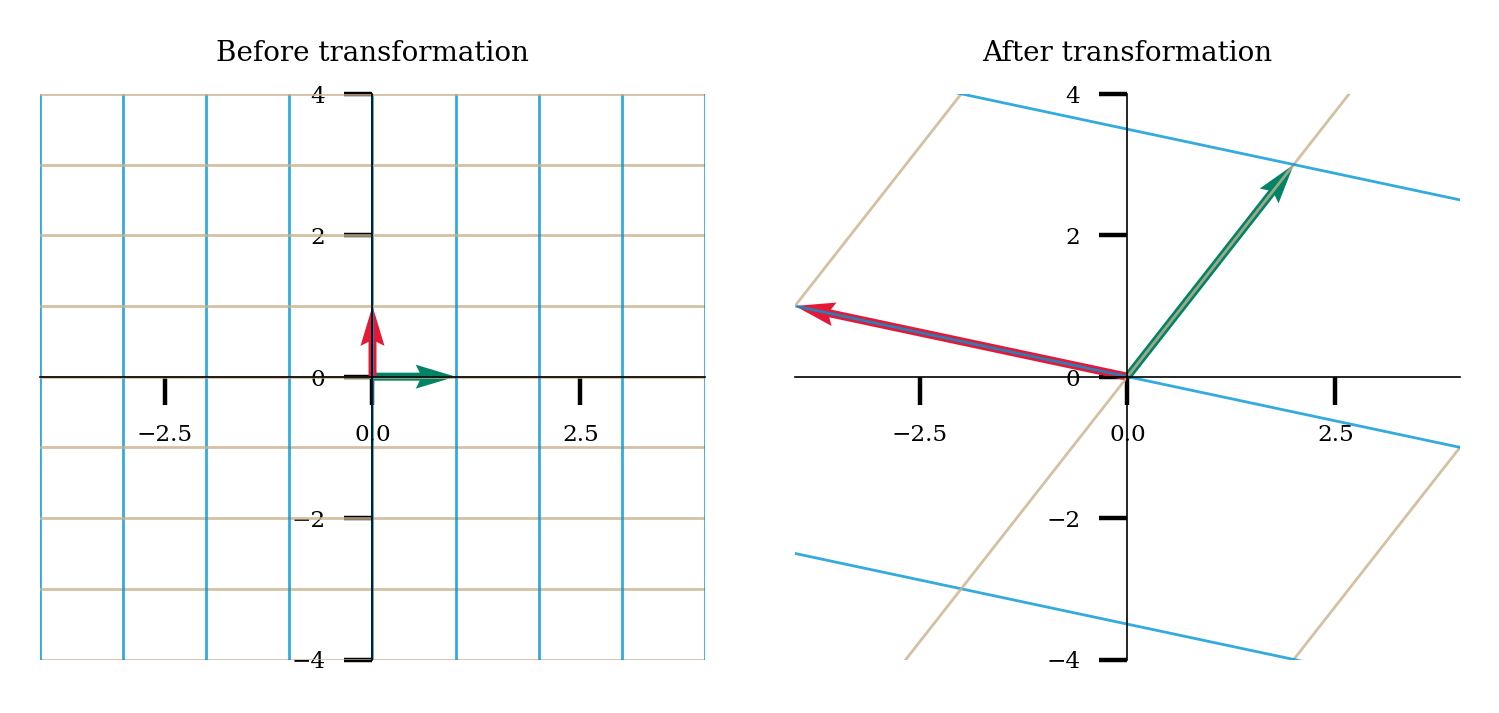

In [4]:
A = np.array([[2, -4], [3, 1]])
plot_linear_transformation(A)

## A) Computing the SVD

Use `np.linalg.svd` to get the SVD of the matrix A. Note that the outputs are not quite the U, S, V we've been discussing. This function outputs $V^T$ directly. Get S/V from the outputs.



In [ ]:
U, s, VT = ...
S = ...
V = ...

TypeError: ignored

## B) SVD step by step transformations

Multiply out the operations of $V^T$, S, and U with vector $\bar{v}$ one at a time. In other words, get $V^T\bar{v}$, then $SV^T\bar{v}$, then $USV^t\bar{v}$. You do not need to do this by hand - use code - but make sure you understand the matrix vector multiplication!

Make sure $USV^t\bar{v}$ = $A\bar{v}$.

Execute the following cell to visualize the vectors.

In [ ]:
v = ...
VTv = ...
SVTv = ...
USVTv = ...
Av = ...
print(USVTv)
print(Av)

### 


 Execute to visualize vector transforms


In [ ]:
# @title
# @markdown Execute to visualize vector transforms
vec_names = [r'$\bar{v}$', r'$SV^T\bar{v}$', r'$V^T\bar{v}$', r'A$\bar{v}$']
vecs = np.array([v,
                 SVTv,
                 VTv,
                 USVTv])

fig, axes = plt.subplots(1, 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axes.set(xlim=[-8, 8], ylim=[-8, 8])
axes.axis('Off')

for i_vec, vec in enumerate(vecs):
  axes.arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True);
  axes.annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec]);

axes.plot([0, 0], [-8, 8], classic, alpha=.4);
axes.plot([-8, 8], [0, 0], classic, alpha=.4);



What transformation is happening to $\bar{v}$ at each step?


**Your text answer**

## (Optional) C) Low rank approximation

We'll explore successful low rank approximations of receptive fields in Tutorial 2 and this will make the concept much more intuitive - the goal of this problem is just to understand the computation involved and what a rank 1 approximation means.

Calculate a rank 1 approximation of A by hand. Specifically, compute:

$$\text{Rank 1 approx } = B = s_1\bar{u}_1\bar{v}_1^T $$

where $s_1$ is the first (highest) singular value and $\bar{u}_1$ and $\bar{v}_1$ are the corresponding columns of U and V.

Show your work for the computation! You should round to 2 places after the decimal.

**Your math answer** show your work!

Compare B to the original matrix A. What does a rank 1 approximation mean? What is the computation "trying to do"? What is happening with the columns/rows of B?

**Your text answer here**

Note that the rank 1 approximation here is not great because our matrix is not anywhere close to rank 1! We would fully recover our matrix with a rank 2 approximation - $ A = s_1\bar{u}_1\bar{v}_1^T + s_2\bar{u}_2\bar{v}_2^T$ - since A is 2 x 2 and has maximum rank of 2.



## (Optional) Extra info: Orthogonal matrices can also reflect

Execute the next cell to visualize the transformation at each step of SVD (by $V^T$, then $S$, then $U$). You will notice that it isn't simply rotation, then scaling, then a rotation. Both $V^T$ and $U$ enact a reflection in addition to a rotation. Orthogonal matrices can reflect in addition to rotating space.

We could get an SVD without reflection if we hadn't ordered our columns by the size of the singular values.  If we switched the columns in U, S, and V, we would see just a rotation, then scaling, then another rotation (show below).

 Execute this cell to visualize transformations


In [ ]:
# @markdown Execute this cell to visualize transformations

plot_linear_transformations(VT, S, U, unit_vector=True, unit_circle=False)


NameError: ignored

 Execute this cell to visualize transformations with permuted columns


In [ ]:
# @markdown Execute this cell to visualize transformations with permuted columns

plot_linear_transformations(V[:, [1, 0]].T, np.diag(s[::-1]), U[:, [1, 0]], unit_vector=True, unit_circle=False)


NameError: ignored

# Exercise 2: PCA implementation and correlation exploration

### Modified from NMA W1D5 T2

In this exercise, you will implement PCA, apply it to 2 dimensional data, and examine the effects of correlations between dimensions.

 Execute this cell to generate some data (X)


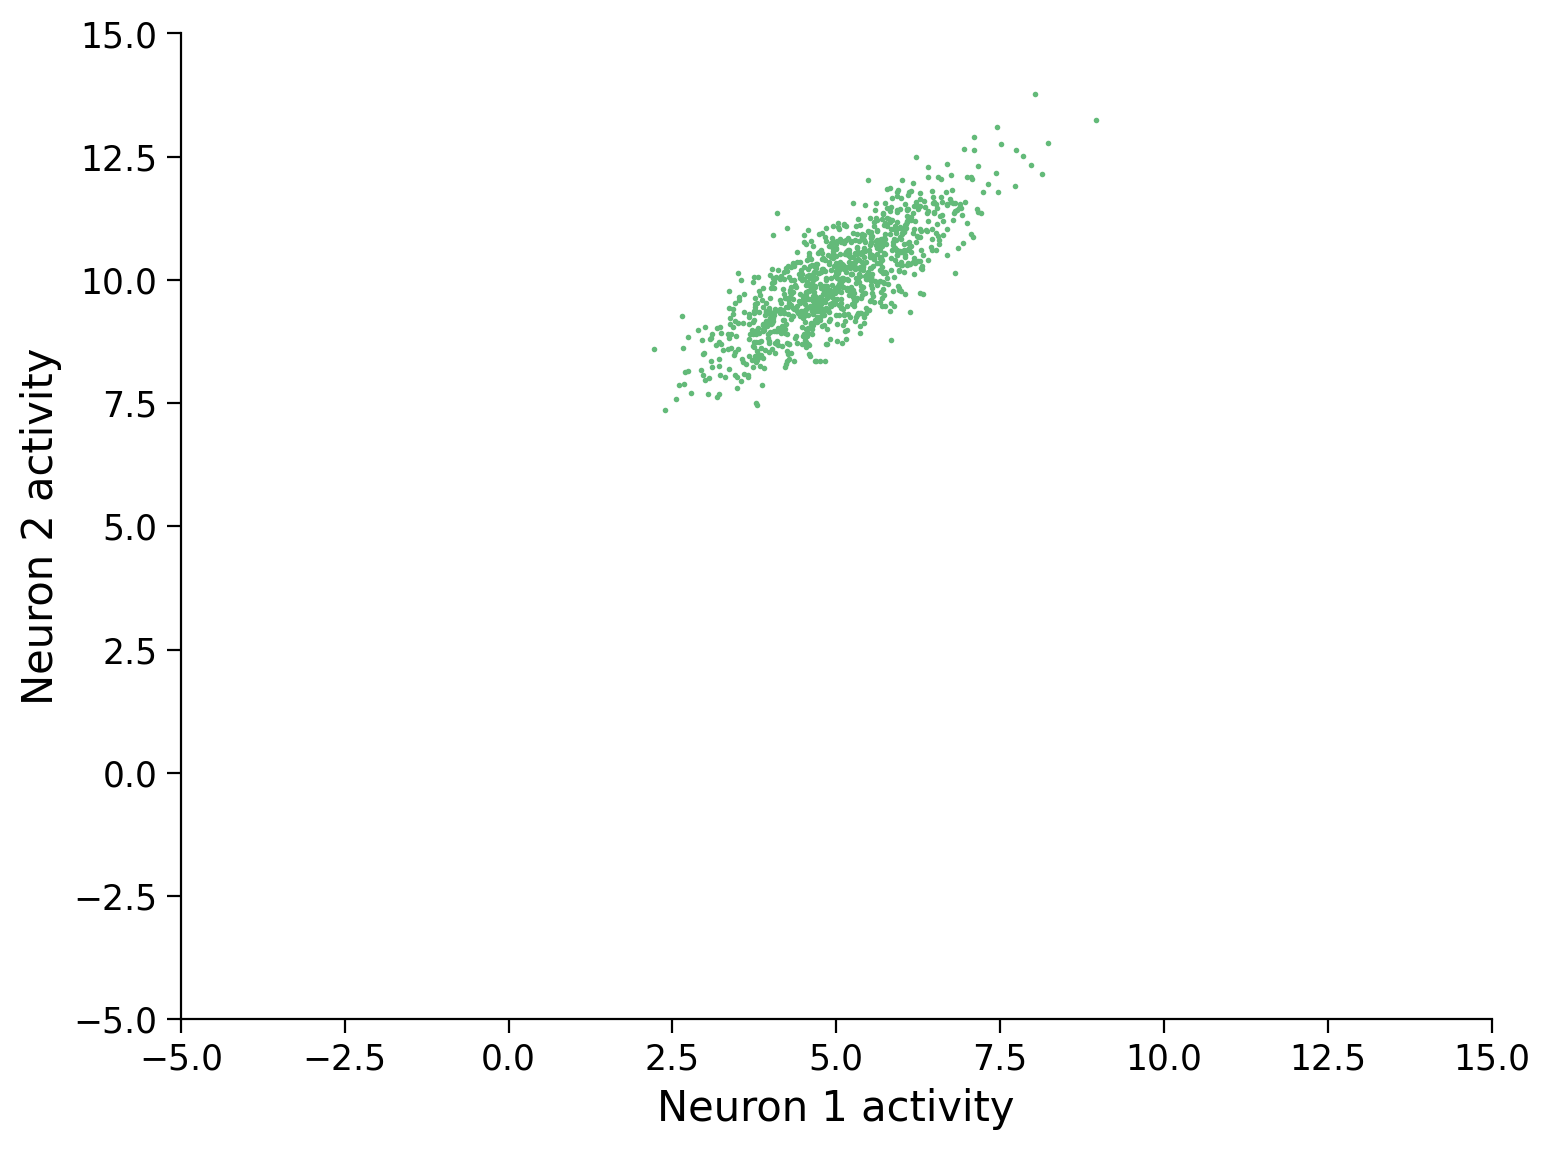

In [5]:
# @markdown Execute this cell to generate some data (X)
np.random.seed(123)
variance_1 = 1
variance_2 = 1
corr_coef = 0.8
cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
X =  np.random.multivariate_normal([5, 10], cov_matrix, size=1000)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:, 1], s=1, color='#63BA79');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set(xlabel='Neuron 1 activity', ylabel='Neuron 2 activity', xlim=[-5, 15], ylim=[-5, 15]);

## A) Interactive Demo: Identifying first principal component

Let's take a subset of our data as shown below and mean subtract it. Play with the interactive demo. About which value of theta represents the first principal component? Why?


 Make sure you execute this cell to enable the widget!


In [6]:
# @markdown Make sure you execute this cell to enable the widget!

def plot_potential_component(theta=180):
  n_points = 30

  mean_subtracted_X = X - np.mean(X, 0)

  fig, ax = plt.subplots()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  ax.set(xlabel='Neuron 1 activity', ylabel='Neuron 2 activity', xlim=[-5, 5], ylim=[-5, 5]);

  w = np.asarray([np.cos(theta*np.pi/180), np.sin(theta*np.pi/180)])[None, :];
  z = mean_subtracted_X[:n_points, :] @ w.T @ w;
  for i in range(n_points):
    ax.plot([mean_subtracted_X[i,0], z[i,0]], [mean_subtracted_X[i,1], z[i,1]], 'r')

  ax.plot(w[0, 0]*5*np.array([-1, 1]), w[0, 1]*5*np.array([-1, 1]), 'k')
  ax.scatter(z[:,0], z[:, 1],  color='r')
  ax.scatter(mean_subtracted_X[:n_points,0], mean_subtracted_X[:n_points, 1], color='#63BA79');
  plt.show()

_ = widgets.interact(plot_potential_component, theta = (0, 180, 1), fontsize=60)

interactive(children=(IntSlider(value=180, description='theta', max=180), Output()), _dom_classes=('widget-int…

**Your text answer**

## B) Implement PCA

Let's first implement PCA! We will build a function that takes in data and returns the transformed data, the principal components, and the variance explained by each component.

We will use an implementation involving the eigenvectors/eigenvalues of the covariance matrix (as opposed to using SVD).


In [ ]:
def pca(X):
  """
  Sorts eigenvalues and eigenvectors in decreasing order.

  Args:
    X (numpy array of floats): Data matrix each column corresponds to a
                               different random variable

  Returns:
    (numpy array of floats)  : Data projected onto the new basis
    (numpy array of floats)  : Vector of eigenvalues
    (numpy array of floats)  : Corresponding matrix of eigenvectors

  """

  # Subtract the mean of X
  X = ...

  # Calculate the sample covariance matrix
  cov_matrix = ... # hint: covariance matrix = (1/n)X^TX

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = ... # hint: use np.linalg.eig

  # Sort the eigenvalues in descending order using a helper function
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  transformed_data = ... # hint: remember U = XV

  return transformed_data, evectors, evals

# Uncomment below once you have filled in the above function

# Perform PCA on the data matrix X
#X_pca, evectors, evals = pca(X)

# Plot the data projected into the new basis
#plot_pca_transformation(X, X_pca)

Note that the correlation between dimensions goes to 0 after the transformation to the principal components basis! This is a property of PCA: it decorrelates the data.

## C) Visualize variance explained

We want to create a plot telling us the percent of variance explained by each principal component (here we have just two). Determine what information you need for this (the inputs) and complete the function below.

In [ ]:
def plot_variances(...):

   percent_explained_variance = ...

   fig, ax = plt.subplots()
   colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
   ax.plot(percent_explained_variance, '-o', color=colors[4])
   ax.set(ylim=[0, 1], ylabel='% Explained Variance', xlabel='Component number', xticks=np.arange(len(percent_explained_variance)))

plot_variances(...)

## D) Interactive Demo: Exploration of the correlation coefficient

Run the following cell and use the slider to change the correlation coefficient of the data. This will update a plot of the data with the principal components overlaid and a plot of percentage of explained variance.

**Questions:**
* Can you find a correlation coefficient value for which the components have equal explained variance?
* Can you find a value for which only only one component explains any variance?

 Make sure you execute this cell to enable the widget!


In [7]:
# @markdown Make sure you execute this cell to enable the widget!

def refresh(corr_coef=.8):
  cov_matrix = calculate_cov_matrix(variance_1, variance_2, corr_coef)
  X = X =  np.random.multivariate_normal([0, 0], cov_matrix, size=1000)
  score, evectors, evals = pca(X)
  plot_data_and_PCs(X, evectors)
  plot_variances(evals)
  plt.show()

_ = widgets.interact(refresh, corr_coef=(-1, 1, .1), fontsize=60)

interactive(children=(FloatSlider(value=0.8, description='corr_coef', max=1.0, min=-1.0), Output()), _dom_clas…

**Your text answer**

## Optional advanced challenge: PCA implementation with SVD

Take the PCA function from part A and implement with SVD instead of with the eigenvectors of the covariance matrix.



In [ ]:
def pca_with_SVD(X):

    ...

# Exercise 3: PCA of images
## Modified from NMA W1D5 T3

In this exercise, we will look at the PCA of images. We will use images from the MNIST dataset, which is a dataset of handdrawn numbers (0-9). We're using this data instead of more neuroscience related data because it's a small dataset that's easy to interpret. Everything we will learn here could be applied to, for example, the frames of a video of a mouse performing a task.



The MNIST dataset consists of a 70,000 images of individual handwritten digits. Each image is a 28x28 pixel grayscale image. For convenience, each 28x28 pixel image is often unravelled into a single 784 (=28*28) element vector (a process called flattening the images), so that the whole dataset is represented as a 70,000 x 784 matrix. Each row represents a different image, and each column represents a different pixel.

Execute the following cell to load the MNIST dataset and plot the first nine images.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name='mnist_784')
X = np.array(mnist.data)
plot_sample_images(X)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## A) Explained variances

We will first perform PCA and plot the cumulative percentage explained variance over components. Note that this is related to our earlier plots but now we are plotting the percentage of explained variance **cumulatively**. Execute the next cell to do this.

- How many principal components are required to explain 90% of the variance?
- How does the intrinsic dimensionality of this dataset compare to its extrinsic dimensionality?


In [ ]:
transformed_data, evectors, evals = pca(X)
variance_explained = get_variance_explained(evals)
plot_variance_explained(variance_explained)

NameError: ignored

**Your text answer**

## B) PCA Reconstruction

Let's try projecting down onto our reduced dimensionality PCA space and then **reconstructing** our images from the low-D space.

To see this, recall that to perform PCA we projected the data $\bf X$ onto the eigenvectors of the covariance matrix:
\begin{equation}
\bf U = X V
\end{equation}
where $U$ is the transformed data, $X$ is the data matrix, and $V$ is the components matrix.

Since $\bf V$ is an orthogonal matrix, ${\bf V}^{-1} = {\bf V}^T$. We can reconstruct by:

\begin{equation}
\bf X = U V^T
\end{equation}

To reconstruct the data from a low-dimensional approximation, we just have to truncate these matrices.  Let's call ${\bf U}_{1:K}$ and ${\bf V}_{1:K}$ as keeping only the first $K$ columns of this matrix. Then our reconstruction is:
\begin{equation}
{\bf \hat X = U}_{1:K} ({\bf V}_{1:K})^T.
\end{equation}

Complete the following function to reconstruct the images from the top K components.

In [ ]:
def reconstruct_data(transformed_data, evectors, X_mean, K):
  """
  Reconstruct the data based on the top K components.

  Args:
    transformed_data (numpy array of floats)    : data projected onto PCA basis
    evectors (numpy array of floats) : Matrix of eigenvectors
    X_mean (numpy array of floats)   : Vector corresponding to data mean
    K (scalar)                       : Number of components to include

  Returns:
    (numpy array of floats)          : Matrix of reconstructed data

  """

  #################################################
  ## TO DO for students: Reconstruct the original data in X_reconstructed
  # Comment once you've filled in the function
  raise NotImplementedError("Student exercise: reconstructing data function!")
  #################################################

  # Reconstruct the data from the score and eigenvectors
  # Don't forget to add the mean!!
  X_reconstructed =  ...

  return X_reconstructed


K = 100

# Fill in below then uncomment the last line

# Reconstruct the data based on all components
X_mean = ...
X_reconstructed = reconstruct_data()

# Plot the data and reconstruction
# plot_reconstructions(X, X_reconstructed)

## C) Interactive Demo: Reconstruct the data matrix using different numbers of PCs

Now run the code below and experiment with the slider to reconstruct the data matrix using different numbers of principal components.


-  How many principal components are necessary to reconstruct the numbers (by eye)? How does this relate to the intrinsic dimensionality of the data?
- Do you see any information in the data with only a single principal component?

 Make sure you execute this cell to enable the widget!


In [ ]:
# @markdown Make sure you execute this cell to enable the widget!


def refresh(K=100):
  X_reconstructed = reconstruct_data(transformed_data, evectors, X_mean, K)
  plot_reconstructions(X, X_reconstructed)
  plt.title('Reconstructed, K={}'.format(K))
  plt.show()

_ = widgets.interact(refresh, K=(1, 784, 10))

**Your text answer**

## D) Visualization of the principal components

We can visualize the principal components as images by reversing the flattening. Here we plot using a differenet colormap than black & white as it highlights more structure.

* What structure do you see in the first principal component? What kinds of images would this basis vector differentiate?
* Try visualizing the second and third basis vectors. Do you see any structure? What about the 100th basis vector? 500th? 700th?

In [ ]:
  plot_principal_components(evectors[:, 0])

**Your text answer**

## (Read only) E) Denoising with PCA

We will add some noise to our images to see how PCA reconstructions can be helpful for reducing noise. In this case, we will set 20% of the pixels to random values. We will then visualize some of the noisy images and the resulting cumulative variance explained plot.

In the next cell, we will project the images onto the original PCA space (from the clean, not noisy, data) and then reconstruct from the top 50 components. Observe that this removes the noise quite effectively!

 Execute this cell to visualize noisy data


In [ ]:
# @markdown Execute this cell to visualize noisy data
np.random.seed(2020)  # set random seed
X_noisy = add_noise(X, .2)
score_noisy, evectors_noisy, evals_noisy = pca(X_noisy)
variance_explained_noisy = get_variance_explained(evals_noisy)


plot_sample_images(X_noisy)
plot_variance_explained(variance_explained_noisy)

 Execute to visualize denoised reconstructions


In [ ]:
# @markdown Execute to visualize denoised reconstructions
X_noisy_mean = np.mean(X_noisy, 0)
projX_noisy = np.matmul(X_noisy - X_noisy_mean, evectors)
X_reconstructed = reconstruct_data(projX_noisy, evectors, X_noisy_mean, 50)

plot_reconstructions(X_noisy, X_reconstructed)

# Extra info: PCA & Sklearn

In this tutorial, we created our own functions to compute PCA and reconstruct images so we could better understand the algorithms. Usually though, you would  use `sklearn.decomposition.pca` to perform PCA. Sklearn is a class based package - I have a video explaining the basics of class based programming (object oriented programming) and a video on sklearn as part of my Pandemic Python for Neuroscientists course so check that out if interested.
I'll demonstrate the basics here using some data with 3 features (X).

See docs here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


 Execute to generate some data X


In [ ]:
#  @markdown Execute to generate some data X
np.random.seed(123)
variance_1 = 1
variance_2 = 1
corr_coef = 0.8
cov_matrix = np.array([[1, .2, .3], [.2, 1, .3], [.3, .3, 1]])
X =  np.random.multivariate_normal([5, 10, 2], cov_matrix, size=1000)


In [ ]:
# Import PCA class
from sklearn.decomposition import PCA

# Set up model, tell it the number of components you'll want to keep (if not set, all components will be kept)
pca = PCA(n_components=2)

# Fit the model to your data, aka find the principal components
pca.fit(X)

# Now you can access the principal components
print(pca.components_)

# And the % of explained variance for each component
print(pca.explained_variance_ratio_)

# You can transform your data now
transformed_data = pca.transform(X)

# You could have fit and transformed at the same time if you had wanted
transformed_data = pca.fit_transform(X)

# You can also reconstruct into the original space
reconstruction = pca.inverse_transform(transformed_data)